<a href="https://colab.research.google.com/github/blu3542/InfoSys/blob/main/CreditAnalysis_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pandas numpy matplotlib seaborn


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import requests

In [ ]:

#Current API request is for aggregate data, does not provide speciifc indivduals. Good for anlayzing trends, such as number of complaints over the years given conditions
#Import Consumer Complainta datbase API, making it easier to search through the database
complaintsAPI = requests.get('https://www.consumerfinance.gov/data-research/consumer-complaints/search/api/v1/trends?field=complaint_what_happened&has_narrative=true&lens=overview&sub_lens_depth=10&trend_depth=10&trend_interval=year')
print(complaintsAPI.text)
#Test to see if it actually retrieved anything
print(complaintsAPI.status_code)
#If returns 200, complaints is a valid endpoint to access



                       date  document_count
0  2015-01-01T00:00:00.000Z           54739
1  2016-01-01T00:00:00.000Z           77796
2  2017-01-01T00:00:00.000Z          115115
3  2018-01-01T00:00:00.000Z          118438
4  2019-01-01T00:00:00.000Z          124864
5  2020-01-01T00:00:00.000Z          174343
6  2021-01-01T00:00:00.000Z          203597
7  2022-01-01T00:00:00.000Z          337196
8  2023-01-01T00:00:00.000Z          487434
9  2024-01-01T00:00:00.000Z           35340


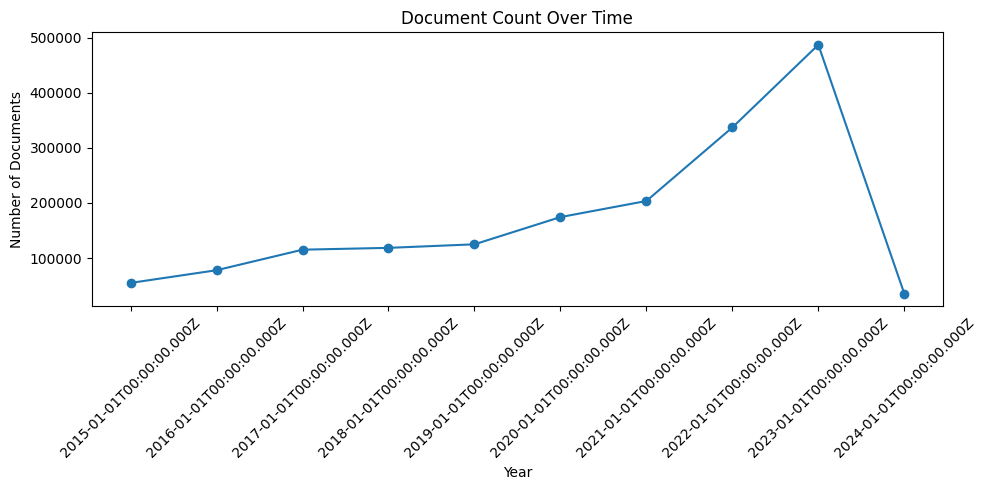

In [9]:
#Response JSON is nested
complaints_json = complaintsAPI.json()
aggregations = complaints_json['aggregations']
date_range_brush = aggregations['dateRangeBrush']['dateRangeBrush']['buckets']

# Create a list of dictionaries with the data you want to convert to a DataFrame
readable_data = [{'date': bucket['key_as_string'], 'document_count': bucket['doc_count']} for bucket in date_range_brush]

# Convert to DataFrame
df = pd.DataFrame(readable_data)

# Print the DataFrame to check
print(df)


# Assuming df is your DataFrame. Document count is a reprsentation of complaints
plt.figure(figsize=(10, 5))
plt.plot(df['date'], df['document_count'], marker='o')
plt.title('Document Count Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Documents')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # Adjust layout to fit the x-axis labels
plt.show()


#original section, for non aggregate data
#records = complaints_json['hits']['hits']  # The exact path might be different

#flattened_data = [hit['_source'] for hit in records]

# Create a DataFrame
#complaints_df = pd.DataFrame(flattened_data)

# Then, create a DataFrame from that list of records


# Now, df should be structured in the way you expected
#print(complaints_df.head())


In [ ]:
# Upload files...slow to uplaod from local machine, so opted for mounting from google drive
#from google.colab import files
#uploaded = files.upload()

In [ ]:
#Upload files via google drive
from google.colab import drive
drive.mount('/content/drive')





Mounted at /content/drive


In [ ]:
#Allow for interaction with operating system (file management, etc)
import os
#print files that have been uploaded
uploaded_files = os.listdir()
print(uploaded_files)

['.config', 'drive', 'sample_data']


In [ ]:
file_path = '/content/drive/My Drive/complaints.csv'
complaints = pd.read_csv(file_path)



In [ ]:
print(complaints.head(10))

In [10]:
#Filter by the ones where consumer consent is provided
consent_provided_complaints = complaints[complaints['Consumer consent provided?'] == 'Consent provided']
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
# Now you can view the first 10 entries where consent was provided
#print(consent_provided_complaints.head(10))
grouped = consent_provided_complaints.groupby(['Product', 'Issue']).size().reset_index(name='Count')

pd.set_option('display.max_colwidth', None)
#print(grouped)

filtered_grouped = grouped[grouped['Count'] > 5000]

# Now, 'filtered_grouped' contains only rows where the count is greater than 5000
# print(filtered_grouped)


sorted_grouped = grouped.sort_values(by='Count', ascending=False)

# Now, select the top 10 rows
top_10_combos = sorted_grouped.head(10)

# Display the top 10 product-issue combinations
print(top_10_combos)


                                                                          Product  \
133  Credit reporting, credit repair services, or other personal consumer reports   
137  Credit reporting, credit repair services, or other personal consumer reports   
132  Credit reporting, credit repair services, or other personal consumer reports   
148                                                               Debt collection   
112                           Credit reporting or other personal consumer reports   
10                                                    Checking or savings account   
111                           Credit reporting or other personal consumer reports   
202                                                                      Mortgage   
158                                                               Debt collection   
114                           Credit reporting or other personal consumer reports   

                                                                

**Analyzing output of the previous cell (See Top10Complaints.png in files)**


1. Examine entries 148 and 158:

148: Product: Debt collection. Issue: Attempts to collect debt not owed.
158: Product: Debt collection. Issue: Failure to provide written notification of debt.

These entries suggest a possible infringement of Regulation F: The Fair Debt Collection Practices Act, which governs the collection of debts and provides protections against practices such as attempting to collect unowed debt and failing to notify debtors properly in writing.

2. Examine entries 133, 132, 112, 111, 114, 137:

133: Product: Credit reporting, credit repair services, or other personal consumer reports. Issue: Incorrect information on your report.
132: Product: Credit reporting, credit repair services, or other personal consumer reports. Issue: Improper use of your report.
112: Product: Credit reporting or other personal consumer reports. Issue: Incorrect information on your report.
111: Product: Credit reporting or other personal consumer reports. Issue: Improper use of your report.
114: Product: Credit reporting or other personal consumer reports. Issue: Company's inadequate investigation into an existing problem.
137: Product: Credit reporting, credit repair services, or other personal consumer reports. Issue: Credit reporting company's inadequate investigation into an existing problem.

3. The frequency of these issues highlights a trend of potential noncompliance with Regulation V: Fair Credit Reporting, which stipulates accurate credit information reporting and the diligent investigation of disputes.

Notice entry 202:

202: Product: Mortgage. Issue: Trouble during payment process.

This entry suggests complications in the mortgage payment process, potentially pointing to a breach of Regulation E: Electronic Fund Transfers, which includes regulations on electronic payment systems.

4. Notice entry 10:

10: Product: Checking or savings account. Issue: Managing an account.

This entry suggests there could be concerns with the way checking and savings accounts are handled, potentially indicating noncompliance with Regulation DD: Truth in Savings, which requires clear disclosure of account terms, and/or Regulation P: Privacy of Consumer Financial Information, which protects the privacy of consumer financial information. The generic nature of "Managing an account" requires further investigation to determine specific regulatory violations.

In [11]:
#Filter by the ones where the complaint was closed with monetary relief
monetary_relief_complaints = complaints[complaints['Company response to consumer'] == 'Closed with monetary relief']
# print(monetary_relief_complaints)


monetary_grouped = monetary_relief_complaints.groupby(['Product', 'Issue']).size().reset_index(name='Count')
monetary_grouped = monetary_grouped.sort_values(by='Count', ascending=False)

#print(monetary_grouped)

#select top 10
top_10_monetary_combos = monetary_grouped.head(10)
print(top_10_monetary_combos)



#sort the ones where complaint was closed with monetary relief by reviewing the product and issues

                        Product  \
9   Checking or savings account   
93  Credit card or prepaid card   
84  Credit card or prepaid card   
0       Bank account or service   
3       Bank account or service   
1       Bank account or service   
40                  Credit card   
14  Checking or savings account   
11  Checking or savings account   
90  Credit card or prepaid card   

                                                           Issue  Count  
9                                            Managing an account  20971  
93               Problem with a purchase shown on your statement  13719  
84                                              Fees or interest   7315  
0                        Account opening, closing, or management   5760  
3                          Problems caused by my funds being low   4844  
1                                       Deposits and withdrawals   4733  
40                                              Billing disputes   4705  
14  Problem with a len

**Analyzing the output of the previous cell (See Top10MonetaryRelief.png in files):**


1. Managing an account (20,971 complaints) - This could relate to several regulations depending on the specifics of the management issue. However, it could potentially involve:

Regulation E: Electronic Fund Transfers, if it involves electronic management of the account.
Regulation DD: Truth in Savings, if it pertains to the disclosure of account terms.



2. Problem with a purchase shown on your statement (13,719 complaints) - This issue could be related to:

Regulation Z: Truth in Lending, if it's related to credit card billing.
Regulation E: Electronic Fund Transfers, for debit card transaction issues.



3. Fees or interest (7,315 complaints) - This issue likely pertains to:

Regulation Z: Truth in Lending, which covers credit card interest rates and fee disclosures.
Regulation DD: Truth in Savings, for issues related to savings and checking account fees.



4. Account opening, closing, or management (5,760 complaints) - This could implicate:

Regulation E: Electronic Fund Transfers, for issues with electronic access to the account during these processes.
Regulation DD: Truth in Savings, if disclosures about the account are not properly made.



5. Problems caused by funds being low (4,844 complaints) - This might relate to:

Regulation Z: Truth in Lending, if it involves credit card over-limit fees or loan issues.
Regulation DD: Truth in Savings, if it's related to overdraft fees for savings or checking accounts.



6. Deposits and withdrawals (4,733 complaints) - This could be covered by:



Regulation CC: Availability of Funds and Collection of Checks, if it involves check deposits.
Regulation E: Electronic Fund Transfers, for electronic deposits and withdrawals.

7. Billing disputes (4,705 complaints) - This issue falls under:



Regulation Z: Truth in Lending, specifically the Fair Credit Billing Act, which deals with resolving billing errors on credit card accounts.



8. Problem with a lender or other company charging... (4,104 complaints) - Without the end of the statement, it's difficult to pinpoint, but it could relate to:

Regulation Z: Truth in Lending, if it involves lending practices and disclosures.



9. Problem caused by funds being low (3,752 complaints) - As before, this could relate to:

Regulation Z: Truth in Lending, for credit-related issues due to low funds.
Regulation DD: Truth in Savings, for fee-related issues with accounts.



10. Problem when making payments (3,515 complaints) - This might involve:

Regulation E: Electronic Fund Transfers, if the payments are made electronically.
Regulation Z: Truth in Lending, if it's related to credit payments.



